
# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives


This experiment predicts pollution w.r.t weather conditions.
At the end of the experiment, you will be able to:

* Understand how to perform Time series prediction using RNN. </br>

**Please ensure GPU is turned ON for this experiment**




In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.talentsprint.com/talentsprint1/archives/sc/aiml/pollution_wrt_weather.mp4" type="video/mp4">
</video>
""")

## Dataset



### Description

In this experiment we use weather and the level of pollution of US embassy in Beijing, China. This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. 

The complete feature list in the raw data is as follows:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.


You can download the dataset from the UCI Machine Learning Repository.

 [Beijing PM2.5 Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

## Domain Information

 Weather is the state of atmosphere at a particular time and place. It comprises of various components such as wind, temperature, pressure etc. We know from experience that the weather conditions, are similar to the conditions obtaining upto that point of time. In other words, the weather conditions of a day can be predicted by studying the weather conditions of previous days. Hence, it is a perfect example of a time series.

Usually the normal dataset only has observations. But, in time series dataset, there must be one time component.This makes it more complicated and challenging to solve.

**Note:** People often confuse between understanding a time series dataset and predicting the future through dataset. Understanding a time series dataset requires detailed analysis so that you can answer why a particular approach/algorithm is the best fit. While predicting the future, involves considering approaches/algorithms that were used in the historical dataset so that you can use the same and predict the next hour weather.

The power of a time series forecasting model is determined by its performance or accuracy at predicting the future. This is often at the expense of being able to explain why a specific prediction was made, what the confidence intervals are and what are the underlying causes.

## AI / ML Technique

**Recurrent Neural Networks:**
Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.

In [ ]:
! wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week5/Exp11/pollution.csv
! wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week5/Exp11/PRSA_data_2010.1.1-2014.12.31.csv
    

### Importing Required Packages

In [ ]:
import torch
from torch import nn

from matplotlib import pyplot as plt
from pandas import read_csv, DataFrame
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

import pandas as pd
import numpy as np

### Data Preprocessing

1. The data is not ready to use. We must prepare it first.

2. Below are the first few rows of the raw dataset.

In [ ]:
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
dataset.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0





- The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

- A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset. we can mark them with 0 values for now.

- The code below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

# Load data
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv', 
                   parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

dataset.drop('No', axis=1, inplace=True)

# Manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# Mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# Drop the first 24 hours
dataset = dataset[24:]

# Summarize first 5 rows
print(dataset.head(5))

# Save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [ ]:
len(dataset)

43800

###  Data Visualization
we can create a quick plot of each series and see what we have.

The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

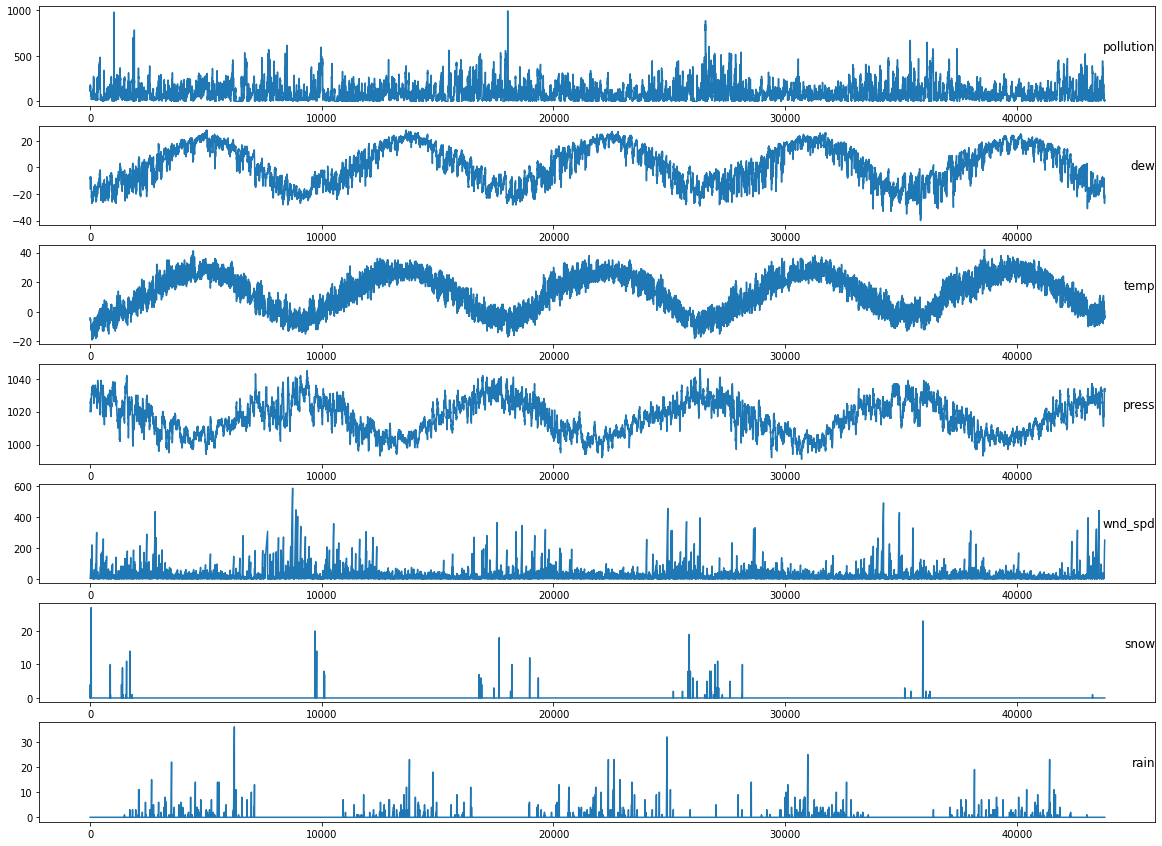

In [ ]:
# Load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# Specify columns to plot, skip 4 becoz it is categorical
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# Plot each column
plt.figure(figsize=(20,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### Preparing Data for Time Series Prediction

- The first step is to prepare the pollution dataset for the Time Series problem.

- This involves framing the dataset as a supervised learning problem and normalizing the input variables.

- We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step. So, the input is features at time step(t-1) and output is pollution at time t. 

- We can transform the dataset using the series_to_supervised() function given in code
- Series to supervised function:

    - Intuition is in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.
    - We can see how positive and negative shifts can be used to create a new DataFrame from a time series with sequences of input and output patterns for a supervised learning problem.
    - This permits not only classical X -> y prediction, but also X -> Y where both input and output can be sequences.
    - The function takes four arguments:

        1. data: Sequence of observations as a list or 2D NumPy array. Required.
        2. n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
        3. n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
        4. dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.
        5. The function returns Pandas DataFrame of series framed for supervised learning.




        
- Steps to convert the  Time Series to a Supervised Learning Problem are:
    
    1. Load the “pollution.csv” dataset 
    2. Label encoded (integer encoded) the wind speed feature
    3. Normalize the Dataset
    4. Transform the dataset into supervised learning problem by calling the function "series_to_supervised"
    


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Convert series to supervised learning

In [ ]:
# Load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values.shape)

# Integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Previous 1 hour features used for framing as supervised learning problem 
# Specify the number of lag hours
n_hours1 = 1
n_features1 = 8
reframed1 = series_to_supervised(scaled, n_hours1, 1)
reframed1.head()
reframed1.shape

(43800, 8)


(43799, 16)

In [ ]:
# Previous 3 hour features used for framing as supervised learning problem 
# Specify the number of lag hours
n_hours2 = 3
n_features2 = 8
reframed2 = series_to_supervised(scaled, n_hours2, 1)
reframed2.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


### Split the Dataset into training and testing data

#### **Case1:** Prediction using prev 1 hour data:
 We will split data into prev 4 years data for training and 1 year of data for testing

**Note:** "After running" the entire experiment, you can come back to this cell to uncomment and change the 4th line of code below, and rerun (for prediction using previous 3 hour data).

In [ ]:
values1 = reframed1.values
n_train_hours1 = 4*365 * 24
n_obs1 = n_hours1 * n_features1    # n_hours2 * n_features2 #(uncomment this line and replace)
print(n_hours1, n_features1)

1 8


In [ ]:
train1 = values1[:n_train_hours1, :]
test1 = values1[n_train_hours1:, :]

# Split into input and outputs by taking last column "pollution" as target"
train_X1, train_y1 = train1[:, :n_obs1], train1[:, -n_features1]
test_X1, test_y1 = test1[:, :n_obs1], test1[:, -n_features1]

train_X_regr = train_X1.reshape((train_X1.shape[0], train_X1.shape[1]))
test_X_regr = test_X1.reshape((test_X1.shape[0], test_X1.shape[1]))

train_y_regr = train_y1
test_y_regr = test_y1
print(train_X_regr.shape, train_y_regr.shape, test_X_regr.shape, test_y_regr.shape)

(35040, 8) (35040,) (8759, 8) (8759,)


## Time Series Prediction Techniques

### RNN

In [ ]:
# To test whether GPU instance is present in the system of not
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
device

Using PyTorch version: 1.9.0+cu102 CUDA: True


device(type='cuda')

In [ ]:
class RNNmodel(nn.Module):
  
  def __init__(self,input_dim,hidden_dim):
    super(RNNmodel,self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = 1 # Since there is only one hidden layer in the architecture
    self.output_dim = 1 # We are having a final regression value
    self.batch_size = 1 # We are treating the entire dataset as 1 batch
        
    # Laying down the architecture primarily to initialize the RNN function
    self.rnn = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    self.linear = nn.Linear(self.hidden_dim, self.output_dim)
    
  def forward(self,input,hidden):
    # Reshape input
    input = input.view(1, input.size(0), input.size(1))
    output, hidden_state = self.rnn(input, hidden) # For each inptut row,the otuput would be a 32 dim

    # Now need to iterate through all the outputs and get a single output by passing through linear layer
    # print(output.size(0),output.size(1),output.size())
    out = []
    for timeStep in range(output.size(1)): 
      selectOutput = output[:,timeStep,:]  
      # print("type of output",type(self.linear(selectOutput)))
      out.append(self.linear(selectOutput))  # self.linear returns a tensor as the parent is a tensor
    return torch.stack(out, dim=1), hidden_state

In [ ]:
# Make training and test sets in torch
train_X_regr = torch.from_numpy(train_X_regr).type(torch.Tensor)
test_X_regr  = torch.from_numpy(test_X_regr ).type(torch.Tensor)
train_y_regr = torch.from_numpy(train_y_regr).type(torch.Tensor).view(-1)
test_y_regr = torch.from_numpy(test_y_regr).type(torch.Tensor).view(-1)

### Training the RNN

**NOTE:  This could take about 10 to 15 mins to run**</br>
This is a regression problem. Hence we focus on the loss reduction, instead of accuracy measures to evaluate the model.

Read the following link [Squeeze](https://pytorch.org/docs/master/generated/torch.squeeze.html)

In [ ]:
hidden_d = 32

# Intialize the RNN with the input dimension and hidden dimension
rnnModel = RNNmodel(train_X_regr.size(1), hidden_d)
rnnModel = rnnModel.to(device)

# Create loss criterion
loss_func = nn.MSELoss()

# Create optimizer
optimizer = torch.optim.Adam(rnnModel.parameters(), lr=0.05)

# We are setting the hidden_state to None within the loop and call rnnModel to populate this after the first epoch.
hidden_state = None

hist = np.zeros(50)  # An array for storing history of loss values

# Pushing the data to cuda
train_X_regr = train_X_regr.to(device)
train_y_regr = train_y_regr.to(device)

for epochs in range(30):

  # Call rnn object with (input,"hidden")
  outputs , hidden_state = rnnModel(train_X_regr, hidden_state) # Even though initially it is set to none..

  # The size of the hidden_state is figured out by the network automatically based on the initialization
  hidden_state = hidden_state.data
  hidden_state = hidden_state.to(device)
  outputs = outputs.to(device)
  
  # Calculate loss
  loss = loss_func(outputs.squeeze(), train_y_regr)
  print("Epoch ", epochs, "MSE: ", loss.item())

  # Storing the loss in an array
  hist[epochs] = loss.item()

  # Set the parameters of gradients to zero
  optimizer.zero_grad()

  # Back propagating the loss
  loss.backward()

  # Adjusting the gradients
  optimizer.step()

Epoch  0 MSE:  0.04568572714924812
Epoch  1 MSE:  3.7960188388824463
Epoch  2 MSE:  0.02843319997191429
Epoch  3 MSE:  0.1910441368818283
Epoch  4 MSE:  0.14631302654743195
Epoch  5 MSE:  0.19469992816448212
Epoch  6 MSE:  0.1450701653957367
Epoch  7 MSE:  0.17131556570529938
Epoch  8 MSE:  0.3521234393119812
Epoch  9 MSE:  0.2857512831687927
Epoch  10 MSE:  0.21433492004871368
Epoch  11 MSE:  0.08430957794189453
Epoch  12 MSE:  0.03496278449892998
Epoch  13 MSE:  0.09942430257797241
Epoch  14 MSE:  0.14523454010486603
Epoch  15 MSE:  0.11068045347929001
Epoch  16 MSE:  0.07906664162874222
Epoch  17 MSE:  0.05070919916033745
Epoch  18 MSE:  0.04373935982584953
Epoch  19 MSE:  0.029112473130226135
Epoch  20 MSE:  0.02307107113301754
Epoch  21 MSE:  0.029519740492105484
Epoch  22 MSE:  0.05079612135887146
Epoch  23 MSE:  0.06328990310430527
Epoch  24 MSE:  0.04324078559875488
Epoch  25 MSE:  0.024067092686891556
Epoch  26 MSE:  0.02836810238659382
Epoch  27 MSE:  0.025442570447921753
Epo

**The graph below, shows the decrease of Loss with epochs**

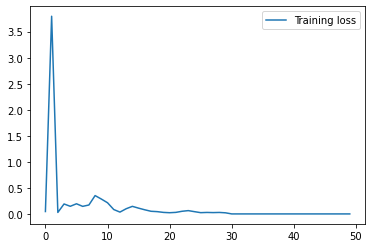

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

### Testing the model

In [ ]:
test_hist = np.zeros(5)
hidden_test = None
test_X_regr = test_X_regr.to(device)
test_y_regr = test_y_regr.to(device)

for i in range(5):
  with torch.no_grad():
    outputs,hidden_test = rnnModel(test_X_regr, hidden_test)
    hidden_test = hidden_test.to(device)
    outputs = outputs.to(device)
    loss = loss_func(outputs.squeeze(), test_y_regr)
    print("Epoch ", i, "MSE: ", loss.item())
    test_hist[i] = loss.item()

Epoch  0 MSE:  0.018787698820233345
Epoch  1 MSE:  0.018778514117002487
Epoch  2 MSE:  0.018778514117002487
Epoch  3 MSE:  0.018778514117002487
Epoch  4 MSE:  0.018778514117002487
